In [1]:
from __future__ import print_function
from datahandling import access_db
from no_big_db_func import get_Ys
from tinydb import Query
from model_scoring_func import gen_terms_key
from pandas import DataFrame
from matplotlib.pyplot import figure, xlabel, tight_layout, legend
from model_analysis import resp_var_val

%matplotlib inline

Q = Query()

In [2]:
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('ticks')
sns.set_style('ticks', {'font.family': 'Cambria'})

In [3]:
sm_db = access_db(3, True)
Ys = get_Ys()
terms_key = gen_terms_key()

In [4]:
names = Ys.columns
# print(names)
names = [i for i in names if i in [#u'rheomix final_deg_time_min',
#                                    u'rheomix stability_time_min']]
#                                    u'ConeCal MARHE_kW_m2', 
#                                    u'ConeCal peak_HRR_kWpm2',
#                                    u'ConeCal tot_smokeprod_m2']]
#                                    u'ConeCal tot_HR_MJpm2',
                                   u'tensile E_t_MPa',
                                   u'tensile epsilon_break_%',
                                   u'tensile sigma_break_MPa']]

In [5]:
#              0      1         2     3             4       5      6 
ingredients = ['PVC', 'Filler', 'FR', 'Stabiliser', 'DINP', 'LDH', 'Sph. Filler']

In [6]:
x_phr = [100.0, 35.0, 10.0, 3.0, 50.0, 3.0, 15.0]

x = [i/sum(x_phr) for i in x_phr]
x

[0.46296296296296297,
 0.16203703703703703,
 0.046296296296296294,
 0.013888888888888888,
 0.23148148148148148,
 0.013888888888888888,
 0.06944444444444445]

In [7]:
sens_all = []
do_increment_sens = True

for column in names:
    equip, d_type = column.split(' ')

    info = sm_db.search((Q.equipment_name == equip) & (Q.data_type == d_type))
    mcode = info[0]['select_mcode']
    mparams = info[0]['model_params']
    
    sens_dtype = []
    
    val = resp_var_val(x, mcode, mparams)
    for part_der_to in range(7):
        sens = 0
        
        if do_increment_sens:
            x_new_phr = x_phr[:]
            x_new_phr[part_der_to] = x_phr[part_der_to] + 1.0
            
            x_new = [i/sum(x_new_phr) for i in x_new_phr]
            
#             x_new = [0]*7
#             increment = 0.01
#             for i in range(7):
#                 if i == part_der_to:
#                     x_new[i] = x[i] + increment
#                 else:
#                     x_new[i] = x[i] - increment/6

            val_new = resp_var_val(x_new, mcode, mparams)
            sens = val_new-val
            sens_dtype.append(sens)
            continue

        if part_der_to in mcode:
            ind = mcode.index(part_der_to)
            sens += mparams[ind]

        for mc, mp in zip(mcode, mparams):
            tk = terms_key[mc]
            if mc > 6:
                if part_der_to in tk:
                    term_left = [i for i in tk if i != part_der_to][0]
                    x_term_left = x[term_left]
                    p_val = mparams[mcode.index(mc)]
                    sens += x_term_left*p_val
                    
        sens_dtype.append(sens)
        
    sens_all += sens_dtype
    
#     fig = figure()
#     df = DataFrame([ingredients, sens_dtype], index=['Ingredients', 'Sensitivity']).T
#     sort_df = df.reindex(DataFrame(df['Sensitivity'].abs()).sort_values('Sensitivity', ascending=False).index)
#     colours = [sns.xkcd_rgb['medium blue'] for i in range(7)]
#     sns.barplot(x='Sensitivity', y='Ingredients', data=sort_df, palette=colours)
#     xlabel('Sensitivity')
#     fig.suptitle(column)

In [8]:
no_done = len(sens_all)/7
categ = []
for i in range(no_done):
    categ += [i for j in range(7)]

In [9]:
# categ_names = ['Final Degradation Time', 'Stability Time']
# categ_names = ['MAHRE', 'pHRR', 'tSP']
categ_names = ['E Modulus', 'Elongation', 'Tensile Strength']
# categ_names = ['Elongation', 'Tensile Strength']

In [10]:
categ = [categ_names[i] for i in categ]
# categ = [names[i] for i in categ]

In [11]:
df = DataFrame([ingredients*no_done, sens_all, categ], index=['Ingredients',
                                                              'Sensitivity', 
                                                              'Response Variable']).T

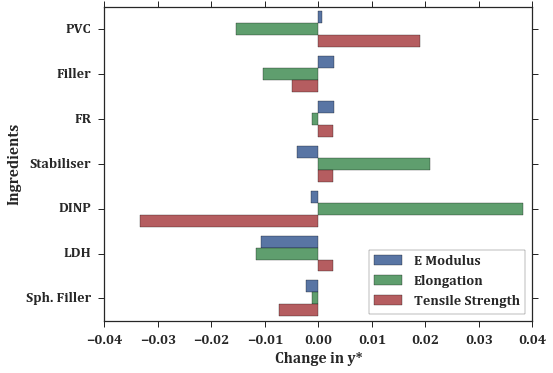

In [14]:

fig = figure()
sns.barplot(x='Sensitivity', y='Ingredients', hue='Response Variable', data=df)
# xlabel('Sensitivity')
xlabel('Change in y*')
tight_layout()
legend(frameon=True, loc=4)
# fig.savefig('phr_Change_Mech.pdf')

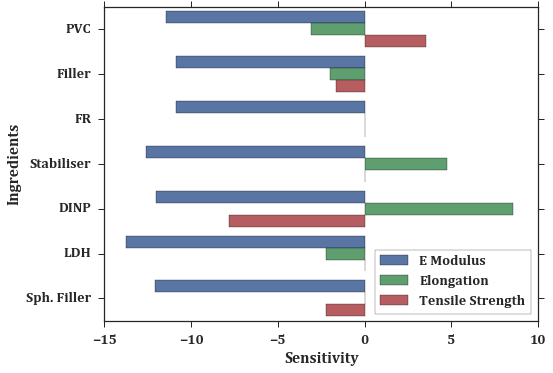

In [153]:
fig = figure()
sns.barplot(x='Sensitivity', y='Ingredients', hue='Response Variable', data=df)
xlabel('Sensitivity')
tight_layout()
legend(frameon=True, loc=4)